# SAX circuit simulator

[SAX](https://flaport.github.io/sax/) is a circuit solver written in JAX, writing your component models in SAX enables you not only to get the function values but the gradients, this is useful for circuit optimization.

This tutorial has been adapted from the SAX Quick Start and example notebooks.

You can install sax with pip (read the SAX install instructions [here](https://github.com/flaport/sax#installation))

```
! pip install gplugins[sax]
```

In [1]:
import json
import logging
import os
import sys
from functools import partial

import gdsfactory as gf
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import meow as mw
import numpy as np
import sax
from gdsfactory.generic_tech import get_generic_pdk
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from rich.logging import RichHandler
from scipy import constants
from sklearn.linear_model import LinearRegression
from tqdm.notebook import trange, tqdm

import gplugins.sax as gs
import gplugins.tidy3d as gt
from gplugins.common.config import PATH

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

## Scatter *dictionaries*

The core datastructure for specifying scatter parameters in SAX is a dictionary... more specifically a dictionary which maps a port combination (2-tuple) to a scatter parameter (or an array of scatter parameters when considering multiple wavelengths for example). Such a specific dictionary mapping is called ann `SDict` in SAX (`SDict ≈ Dict[Tuple[str,str], float]`).

Dictionaries are in fact much better suited for characterizing S-parameters than, say, (jax-)numpy arrays due to the inherent sparse nature of scatter parameters. Moreover, dictionaries allow for string indexing, which makes them much more pleasant to use in this context.

```
o2            o3
   \        /
    ========
   /        \
o1            o4
```

In [2]:
coupling = 0.5
kappa = coupling**0.5
tau = (1 - coupling) ** 0.5
coupler_dict = {
    ("o1", "o4"): tau,
    ("o4", "o1"): tau,
    ("o1", "o3"): 1j * kappa,
    ("o3", "o1"): 1j * kappa,
    ("o2", "o4"): 1j * kappa,
    ("o4", "o2"): 1j * kappa,
    ("o2", "o3"): tau,
    ("o3", "o2"): tau,
}
print(coupler_dict)

{('o1', 'o4'): 0.7071067811865476, ('o4', 'o1'): 0.7071067811865476, ('o1', 'o3'): 0.7071067811865476j, ('o3', 'o1'): 0.7071067811865476j, ('o2', 'o4'): 0.7071067811865476j, ('o4', 'o2'): 0.7071067811865476j, ('o2', 'o3'): 0.7071067811865476, ('o3', 'o2'): 0.7071067811865476}


 it can still be tedious to specify every port in the circuit manually. SAX therefore offers the `reciprocal` function, which auto-fills the reverse connection if the forward connection exist. For example:

In [3]:
coupler_dict = sax.reciprocal(
    {
        ("o1", "o4"): tau,
        ("o1", "o3"): 1j * kappa,
        ("o2", "o4"): 1j * kappa,
        ("o2", "o3"): tau,
    }
)

coupler_dict


{
    ('o1', 'o4'): 0.7071067811865476,
    ('o1', 'o3'): 0.7071067811865476j,
    ('o2', 'o4'): 0.7071067811865476j,
    ('o2', 'o3'): 0.7071067811865476,
    ('o4', 'o1'): 0.7071067811865476,
    ('o3', 'o1'): 0.7071067811865476j,
    ('o4', 'o2'): 0.7071067811865476j,
    ('o3', 'o2'): 0.7071067811865476
}

## Parametrized Models

Constructing such an `SDict` is easy, however, usually we're more interested in having parametrized models for our components. To parametrize the coupler `SDict`, just wrap it in a function to obtain a SAX `Model`, which is a keyword-only function mapping to an `SDict`:


In [4]:
def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    return sax.reciprocal(
        {
            ("o1", "o4"): tau,
            ("o1", "o3"): 1j * kappa,
            ("o2", "o4"): 1j * kappa,
            ("o2", "o3"): tau,
        }
    )


coupler(coupling=0.3)


{
    ('o1', 'o4'): 0.8366600265340756,
    ('o1', 'o3'): 0.5477225575051661j,
    ('o2', 'o4'): 0.5477225575051661j,
    ('o2', 'o3'): 0.8366600265340756,
    ('o4', 'o1'): 0.8366600265340756,
    ('o3', 'o1'): 0.5477225575051661j,
    ('o4', 'o2'): 0.5477225575051661j,
    ('o3', 'o2'): 0.8366600265340756
}

In [5]:
def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )

### Waveguide model

You can create a dispersive waveguide model in SAX.

Lets compute the effective index `neff` and group index `ng` for a 1550nm 500nm straight waveguide

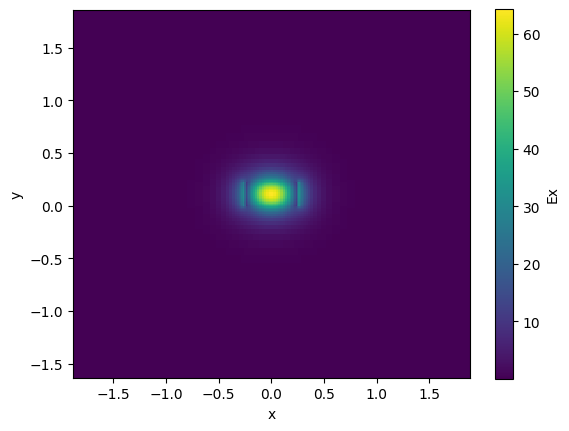

In [6]:
nm = 1e-3
strip = gt.modes.Waveguide(
    wavelength=1.55,
    core_width=500 * nm,
    core_thickness=220 * nm,
    slab_thickness=0.0,
    core_material="si",
    clad_material="sio2",
    group_index_step=10 * nm,
)
strip.plot_field(field_name="Ex", mode_index=0)  # TE

In [7]:
neff = strip.n_eff[0]
print(neff)

(2.511347336097549+4.4277762812653595e-05j)


In [8]:
ng = strip.n_group[0]
print(ng)

4.178039693572401


In [9]:
straight_sc = partial(gs.models.straight, neff=neff, ng=ng)

(-1.0, 1.0)

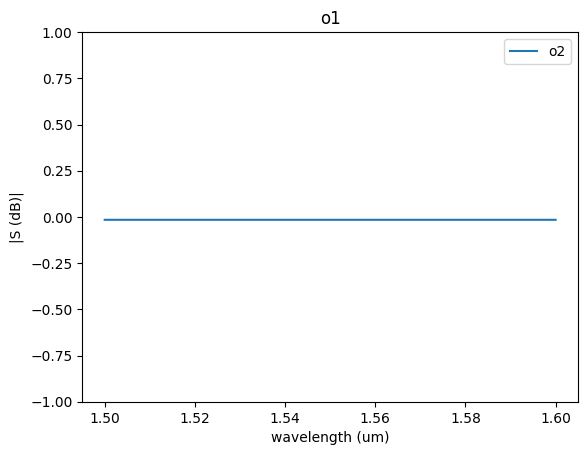

In [10]:
gs.plot_model(straight_sc)
plt.ylim(-1, 1)

<Axes: title={'center': 'o1'}, xlabel='wavelength (um)', ylabel='angle (rad)'>

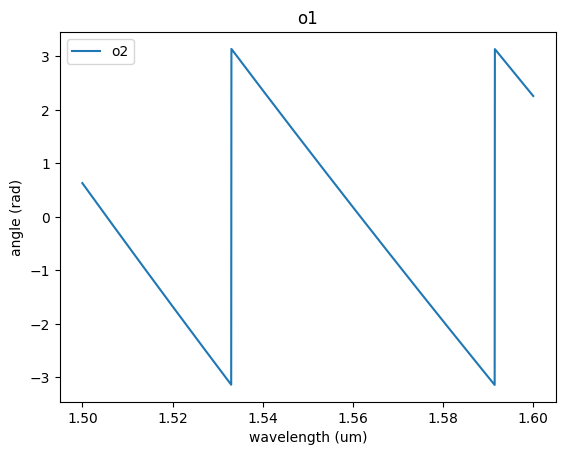

In [11]:
gs.plot_model(straight_sc, phase=True)

### Coupler model

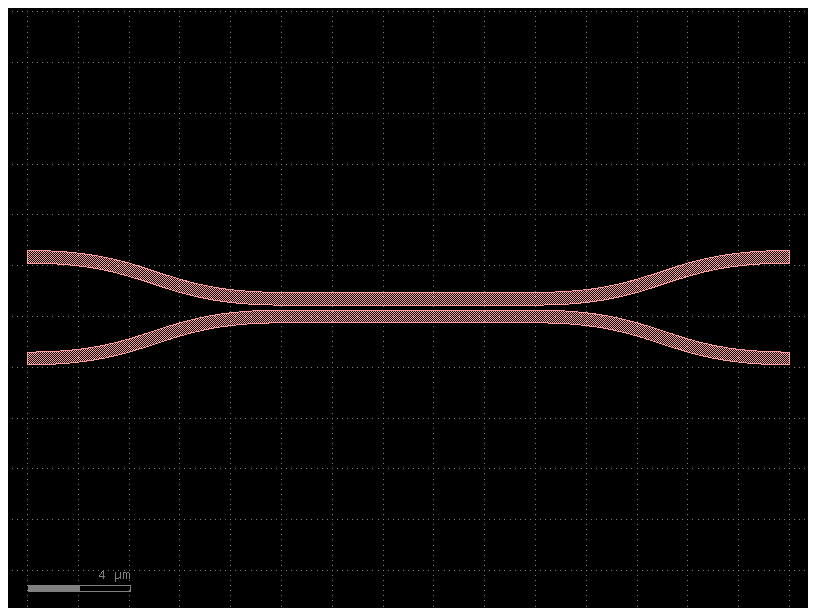

In [12]:
c = gf.components.coupler(length=10, gap=0.2)
c.plot()

21:32:35 UTC WARNING: The group index was not computed. To calculate group      
             index, pass 'group_index_step = True' in the 'ModeSpec'.           

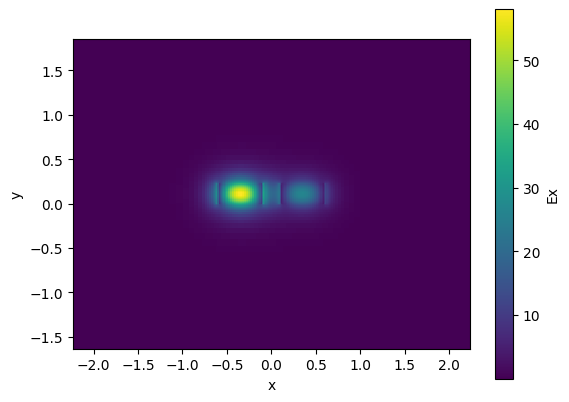

In [13]:
nm = 1e-3
cp = gt.modes.WaveguideCoupler(
    wavelength=1.55,
    core_width=(500 * nm, 500 * nm),
    gap=200 * nm,
    core_thickness=220 * nm,
    slab_thickness=0 * nm,
    core_material="si",
    clad_material="sio2",
)
cp.plot_field(field_name="Ex", mode_index=0)  # even mode

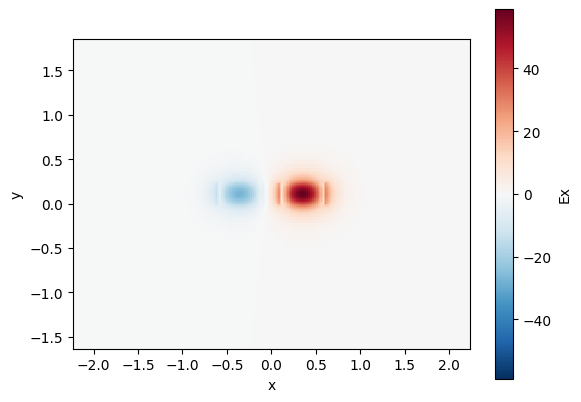

In [14]:
cp.plot_field(field_name="Ex", mode_index=1)  # odd mode


Coupler: WaveguideCoupler(wavelength=array(1.55), core_width=['0.45', '0.45'], core_thickness='0.22', core_material='si', clad_material='sio2', box_material=None, slab_thickness='0.0', clad_thickness=None, box_thickness=None, side_margin=None, sidewall_angle='0.0', sidewall_thickness='0.0', sidewall_k='0.0', surface_thickness='0.0', surface_k='0.0', bend_radius=None, num_modes='4', group_index_step='False', precision='double', grid_resolution='20', max_grid_scaling='1.2', cache_path='/root/.gdsfactory/modes', overwrite='False', gap='0.1')
Effective indices: [2.4637647 +6.57552457e-05j 2.39007229+5.06214923e-05j
 1.9225165 +1.99036730e-04j 1.71420814+2.37015946e-04j]
Mode areas: [0.31003254 0.33258301 0.57286555 0.59002858]
Coupling length: [10.5166863   3.72044606]


  0%|          | 0/11 [00:00<?, ?it/s]

Text(0, 0.5, 'Coupling length (μm)')

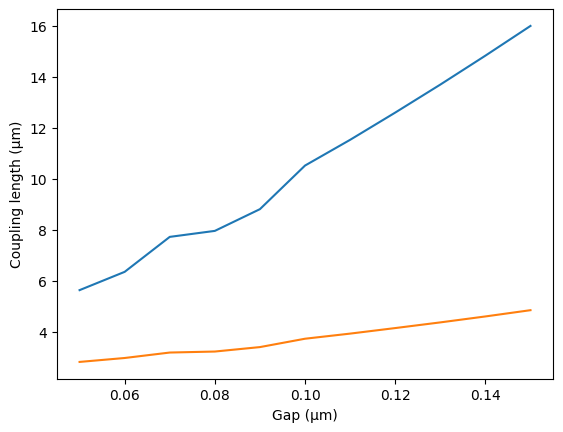

In [15]:
coupler = gt.modes.WaveguideCoupler(
    wavelength=1.55,
    core_width=(0.45, 0.45),
    core_thickness=220 * nm,
    core_material="si",
    clad_material="sio2",
    num_modes=4,
    gap=100 * nm,
)

print("\nCoupler:", coupler)
print("Effective indices:", coupler.n_eff)
print("Mode areas:", coupler.mode_area)
print("Coupling length:", coupler.coupling_length())

gaps = np.linspace(0.05, 0.15, 11)
lengths = gt.modes.sweep_coupling_length(coupler, gaps)
plt.plot(gaps, lengths)
plt.xlabel("Gap (μm)")
plt.ylabel("Coupling length (μm)")

For a 200nm gap the effective index difference `dn` is `0.026`, which means that there is 100% power coupling over 29.4

<Axes: title={'center': 'o1'}, xlabel='wavelength (um)', ylabel='|S (dB)|'>

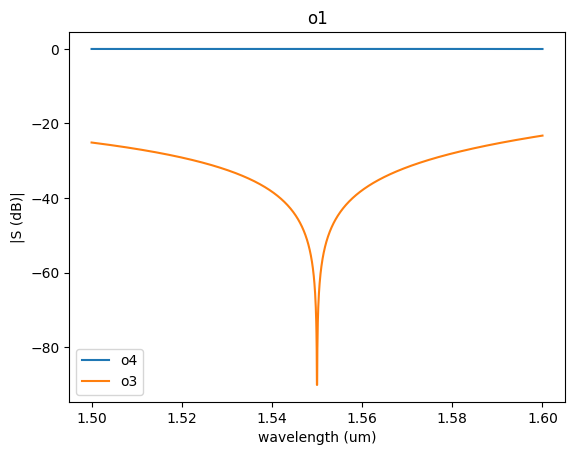

In [16]:
coupler_sc = partial(gs.models.coupler, dn=0.026, length=0, coupling0=0)
gs.plot_model(coupler_sc)

If we ignore the coupling from the bend `coupling0 = 0` we know that for a 3dB coupling we need half of the `lc` length, which is the length needed to coupler `100%` of power.

<Axes: title={'center': 'o1'}, xlabel='wavelength (um)', ylabel='|S (dB)|'>

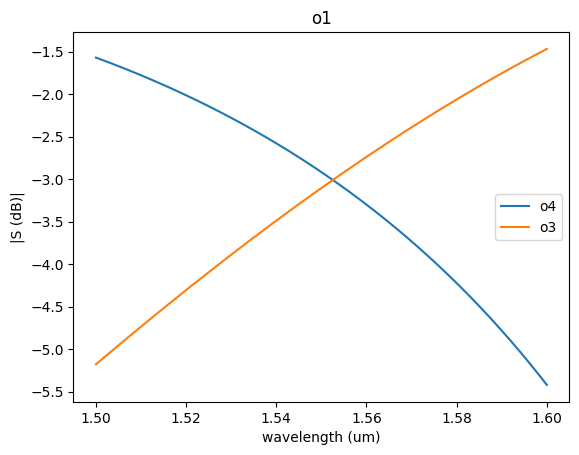

In [17]:
coupler_sc = partial(gs.models.coupler, dn=0.026, length=29.4 / 2, coupling0=0)
gs.plot_model(coupler_sc)

### FDTD Sparameters model

You can also fit a model from Sparameter FDTD simulation data from tidy3d, Lumerical or MEEP.

## Model fit

You can fit a sax model to Sparameter FDTD simulation data.

In [18]:
filepath = "coupler_G224n_L20_S220.csv"

In [19]:
coupler_fdtd = gs.read.model_from_csv(
    filepath=filepath,
    xkey="wavelength_nm",
    prefix="S",
    xunits=1e-3,
)

FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/site-packages/test-data/sp/coupler_G224n_L20_S220.csv'

In [ ]:
gs.plot_model(coupler_fdtd)

Lets fit the coupler spectrum with a linear regression `sklearn` fit

In [ ]:
f = jnp.linspace(constants.c / 1.0e-6, constants.c / 2.0e-6, 500) * 1e-12  # THz
wl = constants.c / (f * 1e12) * 1e6  # um

coupler_fdtd = gs.read.model_from_csv(
    filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3
)
sd = coupler_fdtd(wl=wl)

k = sd["o1", "o3"]
t = sd["o1", "o4"]
s = t + k
a = t - k

Lets fit the symmetric (t+k) and antisymmetric (t-k) transmission

### Symmetric

In [ ]:
plt.plot(wl, jnp.abs(s))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title("symmetric (transmission + coupling)")
plt.legend()
plt.show()

In [ ]:
plt.plot(wl, jnp.abs(a))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title("anti-symmetric (transmission - coupling)")
plt.legend()
plt.show()

In [ ]:
r = LinearRegression()


def fX(x, _order=8):
    return (
        x[:, None] ** (jnp.arange(_order)[None, :])
    )  # artificially create more 'features' (wl**2, wl**3, wl**4, ...)


X = fX(wl)
r.fit(X, jnp.abs(s))
asm, bsm = r.coef_, r.intercept_


def fsm(x):
    return fX(x) @ asm + bsm  # fit symmetric module fiir


plt.plot(wl, jnp.abs(s), label="data")
plt.plot(wl, fsm(wl), label="fit")
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.legend()
plt.show()

In [ ]:
r = LinearRegression()
r.fit(X, jnp.unwrap(jnp.angle(s)))
asp, bsp = r.coef_, r.intercept_


def fsp(x):
    return fX(x) @ asp + bsp  # fit symmetric phase


plt.plot(wl, jnp.unwrap(jnp.angle(s)), label="data")
plt.plot(wl, fsp(wl), label="fit")
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Angle [rad]")
plt.legend()
plt.show()

In [ ]:
def fs(x):
    return fsm(x) * jnp.exp(1j * fsp(x))

Lets fit the symmetric (t+k) and antisymmetric (t-k) transmission

### Anti-Symmetric

In [ ]:
r = LinearRegression()
r.fit(X, jnp.abs(a))
aam, bam = r.coef_, r.intercept_


def fam(x):
    return fX(x) @ aam + bam


plt.plot(wl, jnp.abs(a))
plt.plot(wl, fam(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.legend()
plt.show()

In [ ]:
r = LinearRegression()
r.fit(X, jnp.unwrap(jnp.angle(a)))
aap, bap = r.coef_, r.intercept_


def fap(x):
    return fX(x) @ aap + bap


plt.plot(wl, jnp.unwrap(jnp.angle(a)))
plt.plot(wl, fap(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Angle [rad]")
plt.legend()
plt.show()

In [ ]:
def fa(x):
    return fam(x) * jnp.exp(1j * fap(x))

### Total

In [ ]:
t_ = 0.5 * (fs(wl) + fa(wl))

plt.plot(wl, jnp.abs(t))
plt.plot(wl, jnp.abs(t_))
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")

In [ ]:
k_ = 0.5 * (fs(wl) - fa(wl))

plt.plot(wl, jnp.abs(k))
plt.plot(wl, jnp.abs(k_))
plt.xlabel("Frequency [THz]")
plt.ylabel("Coupling")

In [ ]:
@jax.jit
def coupler(wl=1.5):
    wl = jnp.asarray(wl)
    wl_shape = wl.shape
    wl = wl.ravel()
    t = (0.5 * (fs(wl) + fa(wl))).reshape(*wl_shape)
    k = (0.5 * (fs(wl) - fa(wl))).reshape(*wl_shape)
    sdict = {
        ("o1", "o4"): t,
        ("o1", "o3"): k,
        ("o2", "o3"): k,
        ("o2", "o4"): t,
    }
    return sax.reciprocal(sdict)

In [ ]:
f = jnp.linspace(constants.c / 1.0e-6, constants.c / 2.0e-6, 500) * 1e-12  # THz
wl = constants.c / (f * 1e12) * 1e6  # um

coupler_fdtd = gs.read.model_from_csv(
    filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3
)
sd = coupler_fdtd(wl=wl)
sd_ = coupler(wl=wl)

T = jnp.abs(sd["o1", "o4"]) ** 2
K = jnp.abs(sd["o1", "o3"]) ** 2
T_ = jnp.abs(sd_["o1", "o4"]) ** 2
K_ = jnp.abs(sd_["o1", "o3"]) ** 2
dP = jnp.unwrap(jnp.angle(sd["o1", "o3"]) - jnp.angle(sd["o1", "o4"]))
dP_ = jnp.unwrap(jnp.angle(sd_["o1", "o3"]) - jnp.angle(sd_["o1", "o4"]))

plt.figure(figsize=(12, 3))
plt.plot(wl, T, label="T (fdtd)", c="C0", ls=":", lw="6")
plt.plot(wl, T_, label="T (model)", c="C0")

plt.plot(wl, K, label="K (fdtd)", c="C1", ls=":", lw="6")
plt.plot(wl, K_, label="K (model)", c="C1")

plt.ylim(-0.05, 1.05)
plt.grid(True)

plt.twinx()
plt.plot(wl, dP, label="ΔΦ (fdtd)", color="C2", ls=":", lw="6")
plt.plot(wl, dP_, label="ΔΦ (model)", color="C2")

plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.figlegend(bbox_to_anchor=(1.08, 0.9))
plt.show()

## SAX gdsfactory Compatibility
> From Layout to Circuit Model

If you define your SAX S parameter models for your components, you can directly simulate your circuits from gdsfactory. Let's first define our own MZI:

In [ ]:
@gf.cell
def simple_mzi(delta_length=20.0):
    c = gf.Component()

    # components
    mmi_in = gf.components.mmi1x2()
    mmi_out = gf.components.mmi2x2()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight(length=delta_length/2)

    # references
    mmi_in = c.add_ref(mmi_in, name="mmi_in")
    mmi_out = c.add_ref(mmi_out, name="mmi_out")
    straight_top1 = c.add_ref(half_delay_straight, name="straight_top1")
    straight_top2 = c.add_ref(half_delay_straight, name="straight_top2")
    bend_top1 = c.add_ref(bend, name="bend_top1")
    bend_top2 = c.add_ref(bend, name="bend_top2").dmirror()
    bend_top3 = c.add_ref(bend, name="bend_top3").dmirror()
    bend_top4 = c.add_ref(bend, name="bend_top4")
    bend_btm1 = c.add_ref(bend, name="bend_btm1").dmirror()
    bend_btm2 = c.add_ref(bend, name="bend_btm2")
    bend_btm3 = c.add_ref(bend, name="bend_btm3")
    bend_btm4 = c.add_ref(bend, name="bend_btm4").dmirror()

    # connections
    bend_top1.connect("o1", mmi_in.ports["o2"])
    straight_top1.connect("o1", bend_top1.ports["o2"])
    bend_top2.connect("o1", straight_top1.ports["o2"])
    bend_top3.connect("o1", bend_top2.ports["o2"])
    straight_top2.connect("o1", bend_top3.ports["o2"])
    bend_top4.connect("o1", straight_top2.ports["o2"])

    bend_btm1.connect("o1", mmi_in.ports["o3"])
    bend_btm2.connect("o1", bend_btm1.ports["o2"])
    bend_btm3.connect("o1", bend_btm2.ports["o2"])
    bend_btm4.connect("o1", bend_btm3.ports["o2"])

    mmi_out.connect("o1", bend_btm4.ports["o2"])

    # ports
    c.add_port(
        "o1",
        port=mmi_in.ports["o1"],
    )
    c.add_port("o2", port=mmi_out.ports["o3"])
    c.add_port("o3", port=mmi_out.ports["o4"])
    return c

In [ ]:
mzi = simple_mzi(delta_length=20)
mzi.plot()

In [ ]:
mzi.plot_netlist()

In [ ]:
netlist = mzi.get_netlist()
print(netlist.keys())

The netlist has four different components:

1. mmi1x2
2. mmi2x2
3. straight
4. bend_euler

You need models for each subcomponents to simulate the Component.

In [ ]:
def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def mmi2x2():
    return sax.reciprocal(
        {
            ("o1", "o3"): 0.5**0.5,
            ("o1", "o4"): 1j * 0.5**0.5,
            ("o2", "o3"): 1j * 0.5**0.5,
            ("o2", "o4"): 0.5**0.5,
        }
    )


def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    return sax.reciprocal(
        {
            ("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl),
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


models = {
    "mmi1x2": mmi1x2,
    "mmi2x2": mmi2x2,
    "straight": straight,
    "bend_euler": bend_euler,
}

In [ ]:
circuit, _ = sax.circuit(netlist=netlist, models=models)

In [ ]:
wl = np.linspace(1.5, 1.6)
S = circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

In [ ]:
mzi = simple_mzi(delta_length=40)  # Double the length, reduces FSR by 1/2
mzi.plot()

In [ ]:
circuit, _ = sax.circuit(netlist=mzi.get_netlist(), models=models)

wl = np.linspace(1.5, 1.6, 256)
S = circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

## Layout aware Monte Carlo

You can model the manufacturing variations on the performance of photonics thanks to the fast SAX circuit simulator with layout information and wafer maps of waveguide width and layer thickness variations.

The width and height variations can be extracted from:

- Ring resonators [2017](https://opg.optica.org/oe/fulltext.cfm?uri=oe-25-9-9712&id=363202)
- MZI interferometers [2019](https://ieeexplore.ieee.org/abstract/document/8675367)

## Waveguide Model

Our waveguide model is not very good (it just has 100% transmission and no phase). Let's do something about the phase calculation. To do this, we need to find the effective index of the waveguide in relation to its parameters. We can use [meow](https://github.com/flaport/meow) to obtain the waveguide effective index. Let's first create a `find_waveguide_modes`:

In [ ]:
def find_waveguide_modes(
    wl: float = 1.55,
    n_box: float = 1.4,
    n_clad: float = 1.4,
    n_core: float = 3.4,
    t_slab: float = 0.0,
    t_soi: float = 0.22,
    w_core: float = 0.45,
    du=0.02,
    n_modes: int = 10,
    cache_path: str = "modes",
    replace_cached: bool = False,
):
    length = 10.0
    delta = 10 * du
    env = mw.Environment(wl=wl)
    cache_path = os.path.abspath(cache_path)
    os.makedirs(cache_path, exist_ok=True)
    fn = f"{wl=:.2f}-{n_box=:.2f}-{n_clad=:.2f}-{n_core=:.2f}-{t_slab=:.3f}-{t_soi=:.3f}-{w_core=:.3f}-{du=:.3f}-{n_modes=}.json"
    path = os.path.join(cache_path, fn)
    if not replace_cached and os.path.exists(path):
        return [mw.Mode.parse_obj(mode) for mode in json.load(open(path, "r"))]

    # fmt: off
    m_core = mw.SampledMaterial(name="slab", n=np.asarray([n_core, n_core]), params={"wl": np.asarray([1.0, 2.0])}, meta={"color": (0.9, 0, 0, 0.9)})
    m_clad = mw.SampledMaterial(name="clad", n=np.asarray([n_clad, n_clad]), params={"wl": np.asarray([1.0, 2.0])}) 
    m_box = mw.SampledMaterial(name="box", n=np.asarray([n_box, n_box]), params={"wl": np.asarray([1.0, 2.0])})
    box = mw.Structure(material=m_box, geometry=mw.Box(x_min=- 2 * w_core - delta, x_max= 2 * w_core + delta, y_min=- 2 * t_soi - delta, y_max=0.0, z_min=0.0, z_max=length))
    slab = mw.Structure(material=m_core, geometry=mw.Box(x_min=-2 * w_core - delta, x_max=2 * w_core + delta, y_min=0.0, y_max=t_slab, z_min=0.0, z_max=length))
    clad = mw.Structure(material=m_clad, geometry=mw.Box(x_min=-2 * w_core - delta, x_max=2 * w_core + delta, y_min=0, y_max=3 * t_soi + delta, z_min=0.0, z_max=length))
    core = mw.Structure(material=m_core, geometry=mw.Box(x_min=-w_core / 2, x_max=w_core / 2, y_min=0.0, y_max=t_soi, z_min=0.0, z_max=length))
    
    cell = mw.Cell(structures=[box, clad, slab, core], mesh=mw.Mesh2D( x=np.arange(-2*w_core, 2*w_core, du), y=np.arange(-2*t_soi, 3*t_soi, du), ), z_min=0.0, z_max=10.0)
    cross_section = mw.CrossSection.from_cell(cell=cell, env=env)
    modes = mw.compute_modes(cross_section, num_modes=n_modes)
    # fmt: on

    json.dump([json.loads(mode.json()) for mode in modes], open(path, "w"))

    return modes

We can also create a rudimentary model for the silicon refractive index:

In [ ]:
def silicon_index(wl):
    """a rudimentary silicon refractive index model"""
    a, b = 0.2411478522088102, 3.3229394315868976
    return a / wl + b

We can now easily calculate the modes of a strip waveguide:

In [ ]:
modes = find_waveguide_modes(wl=1.5, n_core=silicon_index(wl=1.5))

The fundamental mode is the mode with index 0:

In [ ]:
mw.visualize(modes[0])

In [ ]:
wavelengths, widths = np.mgrid[1.5:1.6:10j, 0.4:0.6:5j]
neffs = np.zeros_like(wavelengths)
neffs_ = neffs.ravel()

for i, (wl, w) in enumerate(zip(tqdm(wavelengths.ravel()), widths.ravel())):
    modes = find_waveguide_modes(
        wl=wl, n_core=silicon_index(wl), w_core=w, replace_cached=False
    )
    neffs_[i] = np.real(modes[0].neff)

This results in the following effective indices:

In [ ]:
_wls = np.unique(wavelengths.ravel())
_widths = np.unique(widths.ravel())
plt.figure(figsize=(8, 3))
plt.plot(_wls * 1000, neffs)
plt.ylabel("neff")
plt.xlabel("λ [nm]")
plt.title("Effective Index")
plt.grid(True)
plt.figlegend(
    [f"{w=:.2f}um" for w in _widths], ncol=len(widths), bbox_to_anchor=(0.95, -0.05)
)
plt.show()

In [ ]:
_grid = [jnp.sort(jnp.unique(wavelengths)), jnp.sort(jnp.unique(widths))]
_data = jnp.asarray(neffs)


@jax.jit
def _get_coordinate(arr1d: jnp.ndarray, value: jnp.ndarray):
    return jnp.interp(value, arr1d, jnp.arange(arr1d.shape[0]))


@jax.jit
def _get_coordinates(arrs1d: list[jnp.ndarray], values: jnp.ndarray):
    # don't use vmap as arrays in arrs1d could have different shapes...
    return jnp.array([_get_coordinate(a, v) for a, v in zip(arrs1d, values)])


@jax.jit
def neff(wl=1.55, width=0.5):
    params = jnp.stack(jnp.broadcast_arrays(jnp.asarray(wl), jnp.asarray(width)), 0)
    coords = _get_coordinates(_grid, params)
    return jax.scipy.ndimage.map_coordinates(_data, coords, 1, mode="nearest")


neff(wl=[1.52, 1.58], width=[0.5, 0.55])

In [ ]:
wavelengths_ = np.linspace(wavelengths.min(), wavelengths.max(), 100)
widths_ = np.linspace(widths.min(), widths.max(), 100)
wavelengths_, widths_ = np.meshgrid(wavelengths_, widths_)
neffs_ = neff(wavelengths_, widths_)

plt.figure(figsize=(8, 3))
plt.pcolormesh(wavelengths_ * 1000, widths_, neffs_)
plt.ylabel("neff")
plt.xlabel("λ [nm]")
plt.title("Effective Index")
plt.grid(True)
plt.figlegend(
    [f"{w=:.2f}um" for w in _widths], ncol=len(_widths), bbox_to_anchor=(0.95, -0.05)
)
plt.show()

In [ ]:
def straight(wl=1.55, length=10.0, width=0.5):
    S = {
        ("o1", "o2"): jnp.exp(2j * np.pi * neff(wl=wl, width=width) / wl * length),
    }
    return sax.reciprocal(S)


def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def mmi2x2():
    S = {
        ("o1", "o3"): 0.5**0.5,
        ("o1", "o4"): 1j * 0.5**0.5,
        ("o2", "o3"): 1j * 0.5**0.5,
        ("o2", "o4"): 0.5**0.5,
    }
    return sax.reciprocal(S)


def bend_euler(wl=1.5, length=20.0, width=0.5):
    """Let's assume a reduced transmission for the euler bend compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length, width=width).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "mmi2x2": mmi2x2,
    "straight": straight,
}

Even though this still is lossless transmission, we're at least modeling the phase correctly.

In [ ]:
straight()

In [ ]:
mzi = simple_mzi()
mzi

In [ ]:
mzi2, _ = sax.circuit(mzi.get_netlist(recursive=True), models=models)
mzi2()

In [ ]:
wl = jnp.linspace(1.51, 1.59, 1000)
S = mzi2(wl=wl)
plt.plot(wl, abs(S["o1", "o2"]) ** 2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [μm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

## Optimize MZI

We'd like to optimize an MZI such that one of the minima is at 1530nm. To do this, we need to define a loss function for the circuit at 1530nm. This function should take the parameters that you want to optimize as positional arguments:

In [ ]:
@jax.jit
def loss_fn(delta_length):
    S = mzi2(
        wl=1.53,
        straight_top1={"length": delta_length / 2},
        straight_top2={"length": delta_length / 2},
    )
    return jnp.mean(jnp.abs(S["o1", "o2"]) ** 2)

We can use this loss function to define a grad function which works on the parameters of the loss function:

In [ ]:
grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

Next, we need to define a JAX optimizer, which on its own is nothing more than three more functions:  an initialization function with which to initialize the optimizer state, an update function which will update the optimizer state (and with it the model parameters). The third function that's being returned will give the model parameters given the optimizer state.

In [ ]:
initial_delta_length = 21.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

Given all this, a single training step can be defined:

In [ ]:
def step_fn(step, state):
    params = params_fn(state)
    loss = loss_fn(params)
    grad = grad_fn(params)
    state = update_fn(step, grad, state)
    return loss, state

And we can use this step function to start the training of the MZI:

In [ ]:
for step in (
    pb := trange(300)
):  # the first two iterations take a while because the circuit is being jitted...
    loss, state = step_fn(step, state)
    pb.set_postfix(loss=f"{loss:.6f}")

In [ ]:
delta_length = params_fn(state)
delta_length

Let's see what we've got over a range of wavelengths:

In [ ]:
wl = jnp.linspace(1.5, 1.6, 1000)
S = mzi2(
    wl=wl,
    straight_top1={"length": delta_length / 2},
    straight_top2={"length": delta_length / 2},
)
plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1530, 1530], [-1, 2], ls=":", color="black")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

Note that we could've just as well optimized the waveguide width:

In [ ]:
@jax.jit
def loss_fn(width):
    S = mzi2(
        wl=1.53,
        straight_top1={"width": width},
        straight_top2={"width": width},
    )
    return jnp.mean(jnp.abs(S["o1", "o2"]) ** 2)


grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)
initial_width = 0.5
init_fn, update_fn, params_fn = opt.adam(step_size=0.01)
state = init_fn(initial_width)
for step in (
    pb := trange(300)
):  # the first two iterations take a while because the circuit is being jitted...
    loss, state = step_fn(step, state)
    pb.set_postfix(loss=f"{loss:.6f}")

optim_width = params_fn(state)
S = Sw = mzi2(
    wl=wl,
    straight_top1={"width": optim_width},
    straight_top2={"width": optim_width},
)
plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1530, 1530], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

## Layout-aware Monte Carlo

Let's assume the waveguide width changes with a certain correlation length. We can create a 'wafermap' of width variations by randomly varying the width and low pass filtering with a spatial frequency being the inverse of the correlation length (there are probably better ways to do this, but this works for this tutorial).

In [ ]:
def create_wafermaps(
    placements, correlation_length=1.0, num_maps=1, mean=0.0, std=1.0, seed=None
):
    dx = dy = correlation_length / 200
    xs = [p["x"] for p in placements.values()]
    ys = [p["y"] for p in placements.values()]
    xmin, xmax, ymin, ymax = min(xs), max(xs), min(ys), max(ys)
    wx, wy = xmax - xmin, ymax - ymin
    xmin, xmax, ymin, ymax = xmin - wx, xmax + wx, ymin - wy, ymax + wy
    x, y = np.arange(xmin, xmax + dx, dx), np.arange(ymin, ymax + dy, dy)
    if seed is None:
        r = np.random
    else:
        r = np.random.RandomState(seed=seed)
    W0 = r.randn(num_maps, x.shape[0], y.shape[0])

    fx = fftshift(fftfreq(x.shape[0], d=x[1] - x[0]))
    fy = fftshift(fftfreq(y.shape[0], d=y[1] - y[0]))
    fY, fX = np.meshgrid(fy, fx)

    fW = fftshift(fft2(W0))

    if correlation_length >= min(x.shape[0], y.shape[0]):
        fW = np.zeros_like(fW)
    else:
        fW = np.where(np.sqrt(fX**2 + fY**2)[None] > 1 / correlation_length, 0, fW)

    W = np.abs(fftshift(ifft2(fW))) ** 2

    mean_ = W.mean(1, keepdims=True).mean(2, keepdims=True)

    std_ = W.std(1, keepdims=True).std(2, keepdims=True)
    if (std_ == 0).all():
        std_ = 1

    W = (W - mean_) / std_

    W = W * std + mean

    return x, y, W

In [ ]:
placements = mzi.get_netlist()["placements"]
xm, ym, wmaps = create_wafermaps(
    placements,
    correlation_length=100,
    mean=0.5,
    std=0.002,
    num_maps=100,
    seed=42,
)

for i, wmap in enumerate(wmaps):
    if i > 1:
        break
    plt.imshow(wmap, cmap="RdBu")
    plt.show()

In [ ]:
def widths(xw, yw, wmaps, x, y):
    _wmap_grid = [xw, yw]
    params = jnp.stack(jnp.broadcast_arrays(jnp.asarray(x), jnp.asarray(y)), 0)
    coords = _get_coordinates(_wmap_grid, params)

    map_coordinates = partial(
        jax.scipy.ndimage.map_coordinates, coordinates=coords, order=1, mode="nearest"
    )
    w = jax.vmap(map_coordinates)(wmaps)
    return w

Let's now sample the MZI width variation on the wafer map (let's assume a single width variation per point):

In [ ]:
mzi_params = sax.get_settings(mzi2)
placements = mzi.get_netlist()["placements"]
width_params = {
    k: {"width": widths(xm, ym, wmaps, v["x"], v["y"])}
    for k, v in placements.items()
    if "width" in mzi_params[k]
}

S0 = mzi2(wl=wl)
S = mzi2(
    wl=wl[:, None],
    **width_params,
)
ps = plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, color="C0", lw=1, alpha=0.1)
nps = plt.plot(wl * 1e3, abs(S0["o1", "o2"]) ** 2, color="C1", lw=2, alpha=1)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.figlegend([*ps[-1:], *nps], ["MC", "nominal"], bbox_to_anchor=(1.1, 0.9))
rmse = jnp.mean(
    jnp.abs(jnp.abs(S["o1", "o2"]) ** 2 - jnp.abs(S0["o1", "o2"][:, None]) ** 2) ** 2
)
plt.title(f"{rmse=}")
plt.show()

## Compact MZI

Let's see if we can improve variability (i.e. the RMSE w.r.t. nominal) by making the MZI more compact:

In [ ]:
@gf.cell
def compact_mzi():
    c = gf.Component()

    # instances
    mmi_in = gf.components.mmi1x2()
    mmi_out = gf.components.mmi2x2()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight()
    middle_straight = gf.components.straight(length=6.0)
    half_middle_straight = gf.components.straight(3.0)

    # references (sax convention: vars ending in underscore are references)
    mmi_in = c.add_ref(mmi_in, name="mmi_in")

    bend_top1 = c.add_ref(bend, name="bend_top1")
    straight_top1 = c.add_ref(half_delay_straight, name="straight_top1")
    bend_top2 = c.add_ref(bend, name="bend_top2").dmirror()
    straight_top2 = c.add_ref(middle_straight, name="straight_top2")
    bend_top3 = c.add_ref(bend, name="bend_top3").dmirror()
    straight_top3 = c.add_ref(half_delay_straight, name="straight_top3")
    bend_top4 = c.add_ref(bend, name="bend_top4")

    straight_btm1 = c.add_ref(half_middle_straight, name="straight_btm1")
    bend_btm1 = c.add_ref(bend, name="bend_btm1")
    bend_btm2 = c.add_ref(bend, name="bend_btm2").dmirror()
    bend_btm3 = c.add_ref(bend, name="bend_btm3").dmirror()
    bend_btm4 = c.add_ref(bend, name="bend_btm4")
    straight_btm2 = c.add_ref(half_middle_straight, name="straight_btm2")

    mmi_out = c.add_ref(mmi_out, name="mmi_out")

    # connections
    bend_top1.connect("o1", mmi_in.ports["o2"])
    straight_top1.connect("o1", bend_top1.ports["o2"])
    bend_top2.connect("o1", straight_top1.ports["o2"])
    straight_top2.connect("o1", bend_top2.ports["o2"])
    bend_top3.connect("o1", straight_top2.ports["o2"])
    straight_top3.connect("o1", bend_top3.ports["o2"])
    bend_top4.connect("o1", straight_top3.ports["o2"])

    straight_btm1.connect("o1", mmi_in.ports["o3"])
    bend_btm1.connect("o1", straight_btm1.ports["o2"])
    bend_btm2.connect("o1", bend_btm1.ports["o2"])
    bend_btm3.connect("o1", bend_btm2.ports["o2"])
    bend_btm4.connect("o1", bend_btm3.ports["o2"])
    straight_btm2.connect("o1", bend_btm4.ports["o2"])

    mmi_out.connect("o1", straight_btm2.ports["o2"])

    # ports
    c.add_port(
        "o1",
        port=mmi_in.ports["o1"],
    )
    c.add_port("o2", port=mmi_out.ports["o3"])
    c.add_port("o3", port=mmi_out.ports["o4"])
    return c

In [ ]:
compact_mzi1 = compact_mzi()
compact_mzi1

In [ ]:
placements = compact_mzi1.get_netlist()["placements"]
mzi3, _ = sax.circuit(compact_mzi1.get_netlist(recursive=True), models=models)
mzi3()

In [ ]:
mzi_params = sax.get_settings(mzi3)
placements = compact_mzi1.get_netlist()["placements"]
width_params = {
    k: {"width": widths(xm, ym, wmaps, v["x"], v["y"])}
    for k, v in placements.items()
    if "width" in mzi_params[k]
}

S0 = mzi3(wl=wl)
S = mzi3(
    wl=wl[:, None],
    **width_params,
)
ps = plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, color="C0", lw=1, alpha=0.1)
nps = plt.plot(wl * 1e3, abs(S0["o1", "o2"]) ** 2, color="C1", lw=2, alpha=1)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.figlegend([*ps[-1:], *nps], ["MC", "nominal"], bbox_to_anchor=(1.1, 0.9))
rmse = jnp.mean(
    jnp.abs(jnp.abs(S["o1", "o2"]) ** 2 - jnp.abs(S0["o1", "o2"][:, None]) ** 2) ** 2
)
plt.title(f"{rmse=}")
plt.show()

## Phase shifter model

You can create a phase shifter model that depends on the applied volage.
For that you need first to figure out what's the phase shift for different voltages.

In [ ]:
delta_length = 10
mzi_component = gf.components.mzi_phase_shifter(delta_length=delta_length)
mzi_component.plot()

In [ ]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2() -> sax.SDict:
    """Returns a perfect 1x2 splitter."""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0) -> sax.SDict:
    """Returns bend Sparameters with reduced transmission compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


def phase_shifter_heater(
    wl: float = 1.55,
    neff: float = 2.34,
    voltage: float = 0,
    length: float = 10,
    loss: float = 0.0,
) -> sax.SDict:
    """Returns simple phase shifter model"""
    deltaphi = voltage * jnp.pi
    phase = 2 * jnp.pi * neff * length / wl + deltaphi
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
            ("l_e1", "r_e1"): 0.0,
            ("l_e2", "r_e2"): 0.0,
            ("l_e3", "r_e3"): 0.0,
            ("l_e4", "r_e4"): 0.0,
        }
    )


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
    "straight_heater_metal_undercut": phase_shifter_heater,
}

In [ ]:
mzi_component = gf.components.mzi_phase_shifter(delta_length=delta_length)
netlist = sax.netlist(mzi_component.get_netlist())

In [ ]:
mzi_circuit, _ = sax.circuit(netlist=netlist, models=models, backend="filipsson_gunnar")
S = mzi_circuit(wl=1.55)
{k: v for k, v in S.items() if abs(v) > 1e-5}

In [ ]:
wl = np.linspace(1.5, 1.6, 256)
S = mzi_circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

Now you can tune the phase shift applied to one of the arms.

How do you find out what's the name of the netlist component that you want to tune?

You can backannotate the netlist and read the labels on the backannotated netlist or you can plot the netlist

In [ ]:
mzi_component.plot_netlist()

As you can see the top phase shifter instance name `sxt` is hard to see on the netlist.
You can also reconstruct the component using the netlist and look at the labels in klayout.

In [ ]:
mzi_yaml = mzi_component.get_netlist()
mzi_component2 = gf.read.from_yaml(mzi_yaml)
mzi_component2.plot()

The best way to get a deterministic name of the `instance` is naming the reference on your Pcell.

In [ ]:
voltages = np.linspace(-1, 1, num=5)
voltages = [-0.5, 0, 0.5]

for voltage in voltages:
    S = mzi_circuit(
        wl=wl,
        sxt={"voltage": voltage},
    )
    plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, label=str(voltage))
    plt.xlabel("λ [nm]")
    plt.ylabel("T")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

plt.title("MZI vs voltage")
plt.legend()

## Hierarchical circuits

You can also simulate hierarchical circuits, such as lattice of MZI interferometers.


In [ ]:
@gf.cell
def mzis(delta_length=10):
    c = gf.Component()
    c1 = c << simple_mzi(delta_length=delta_length)
    c2 = c << simple_mzi(delta_length=delta_length)
    c2.connect("o1", c1.ports["o2"])

    c.add_port("o1", port=c1.ports["o1"])
    c.add_port("o2", port=c2.ports["o2"])
    return c

In [ ]:
def straight(wl=1.55, length=10.0, width=0.5):
    S = {
        ("o1", "o2"): jnp.exp(2j * np.pi * neff(wl=wl, width=width) / wl * length),
    }
    return sax.reciprocal(S)


def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def mmi2x2():
    S = {
        ("o1", "o3"): 0.5**0.5,
        ("o1", "o4"): 1j * 0.5**0.5,
        ("o2", "o3"): 1j * 0.5**0.5,
        ("o2", "o4"): 0.5**0.5,
    }
    return sax.reciprocal(S)


def bend_euler(wl=1.5, length=20.0, width=0.5):
    """Let's assume a reduced transmission for the euler bend compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length, width=width).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "mmi2x2": mmi2x2,
    "straight": straight,
}

In [ ]:
c2 = mzis()
c2.plot()

In [ ]:
c2.plot_netlist()

In [ ]:
c1 = simple_mzi(delta_length=10)
c1.plot()

In [ ]:
c1.plot_netlist()

In [ ]:
wl = np.linspace(1.5, 1.6)
netlist1 = c1.get_netlist(recursive=True)
circuit1, _ = sax.circuit(netlist=netlist1, models=models)
S1 = circuit1(wl=wl)

netlist2 = c2.get_netlist(recursive=True)
circuit2, _ = sax.circuit(netlist=netlist2, models=models)
S2 = circuit2(wl=wl)

plt.figure(figsize=(14, 4))
plt.plot(1e3 * wl, jnp.abs(S1["o1", "o2"]) ** 2, label="1 MZI")
plt.plot(1e3 * wl, jnp.abs(S2["o1", "o2"]) ** 2, label="2 MZI")
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.legend()
plt.show()